# Exploring the Front Page of Reddit

Reddit is a forum based community website that is broken up into even smaller communities that is dedicated to very specific topics. These smaller communities are called 'subreddits'. Within these subreddits, people around the world can post, vote, and comment. The subreddit url is always indicated by '/r/[subreddit]'

For this project, we will be exploring '/r/popular'. You could argue that this essentially the front page of Reddit as this is what a non-registed user will see when visiting the site. However, once users have registered an account, what each user see is a personalized front page that is compiled of all the subreddits that the user is subscribed to.

The '/r/popular' subreddit, while not technically a subreddit, is a collection of all popular posts of almost all subreddits. When I say 'almost,' that is because /r/popular filters out the NSFW subreddits.

I want to see what types of subreddits make it to /r/popular, so I will be exploring the submissions and its various attributes.

## Setting up PRAW to pull data from the Reddit API

We will be using PRAW(The Python Reddit API Wrapper) to enable us to pull data from the Reddit API. This is tool that makes working with the Reddit API a lot easier.

In [1]:
# Load secret keys from credentials.json
import json
url = 'https://www.reddit.com/'
with open("/Users/Jeremy Ancheta/.secret/reddit_api_secret.json") as f:
    params = json.load(f)

In [2]:
# Import PRAW wrapper and authorize Reddit instance
import praw
reddit = praw.Reddit(client_id=params['client_id'], 
                     client_secret=params['api_key'],
                     password=params['password'], 
                     user_agent='jeremy_reddit_analysis',
                     username=params['username'])

In [3]:
# Accessing the subreddit using the subreddit PRAW model
popular_subreddit = reddit.subreddit('popular')

## Creating a Pandas Dataframe

Now that we have imported the PRAW tool. It is time to put our dataframe together. I want to pull data from top posts from the last year. I want to limit our dataframe to 200 rows for now.

### Compiling lists of submission attributes

In [4]:
submission_title = []
submission_subreddit = []
time = []
num_upvotes = []
num_comments = []
upvote_ratio = []
link_flair = []
redditor = []
i = 0

for submission in popular_subreddit.top('year', limit = 200):
    i += 1
    submission_title.append(submission.title)
    submission_subreddit.append(submission.subreddit)
    time.append(submission.created_utc)
    num_upvotes.append(submission.score)
    num_comments.append(submission.num_comments)
    upvote_ratio.append(submission.upvote_ratio)
    link_flair.append(submission.link_flair_text)
    redditor.append(submission.author)
    if i%10 == 0:
        print(f'{i} submissions completed')

10 submissions completed
20 submissions completed
30 submissions completed
40 submissions completed
50 submissions completed
60 submissions completed
70 submissions completed
80 submissions completed
90 submissions completed
100 submissions completed
110 submissions completed
120 submissions completed
130 submissions completed
140 submissions completed
150 submissions completed
160 submissions completed
170 submissions completed
180 submissions completed
190 submissions completed
200 submissions completed


In [5]:
import pandas as pd

popular_df = pd.DataFrame(
    {'submission_title': submission_title,
     'submission_subreddit': submission_subreddit,
     'time': time,
     'num_upvotes': num_upvotes,
     'num_comments': num_comments,
     'upvote_ratio': upvote_ratio,
     'link_flair': link_flair,
     'redditor': redditor
    })

## Exploring and Cleaning the Dataset

Now that we have the dataset compiled. Let's explore the dataset to see if we need to clean anything before we start visualizing the dataset

In [6]:
import pandas_profiling
import numpy as np

pandas_profiling.ProfileReport(popular_df)

Number of variables,8
Number of observations,200
Total Missing (%),10.8%
Total size in memory,12.6 KiB
Average record size in memory,64.4 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),1
Rejected,0


### Missing Values

There is 172 missing values from the link_flair attribute. A link flair is essentially a submission category within the subreddit. I initially thought there would be some interesting data here to drill down the category beyond just the subreddit it is connected to. Since there is 172 missing values, I will just remove this from the dataset.

In [7]:
#removing the link flair column
popular_df = popular_df.drop(columns = 'link_flair')
popular_df.head()

,submission_title,submission_subreddit,time,num_upvotes,num_comments,upvote_ratio,redditor
0,Heat index was 110 degrees so we offered him a...,aww,1.532051e+09,274903,3686,0.98,FootLoosePickleJuice
1,I got off the horse by accident right before a...,gaming,1.543628e+09,226506,2246,0.97,springfart
2,Given that reddit just took a $150 million inv...,pics,1.549640e+09,224770,6488,0.94,FreeSpeechWarrior
3,"People who haven't pooped in 2019 yet, why are...",AskReddit,1.546377e+09,221854,8183,0.91,ShoddySubstance
4,This person sold their VHS player on eBay and ...,pics,1.550367e+09,212094,2567,0.88,effectivepep


There is also 1 missing values from the redditor column. This is interesting because a submission is made by a redditor, so I figured there would be no missing values from this column. Let's explore this row to see if we can figure out why there is no redditor.

In [8]:
missing_values = popular_df[popular_df['redditor'].isna()]
missing_values

,submission_title,submission_subreddit,time,num_upvotes,num_comments,upvote_ratio,redditor
92,Please save us. Please help us. We need your h...,pics,1.533505e+09,151115,5402,0.87,None


While I can't pinpoint why there is no redditor name. I can speculate that this is because the account no longer exists. Since I am not that interested in the redditor. I will leave it in.

### Fixing the Time Column

Currently the time column is in UNIX time. This isn't easily readable so we should convert this into a date and time format.

In [9]:
popular_df['time'] = pd.to_datetime(popular_df['time'], unit = 's')

In [10]:
popular_df['time'].head()

0   2018-07-20 01:44:38
1   2018-12-01 01:37:22
2   2019-02-08 15:40:21
3   2019-01-01 21:06:27
4   2019-02-17 01:26:24
Name: time, dtype: datetime64[ns]

### Changing the Data Type of the Subreddit Column

The dtype for this column is currently a unsupported type. We should change this to categorical so it will be easier for our data analysis/visualization.

In [11]:
popular_df['submission_subreddit'] = popular_df['submission_subreddit'].astype('category')

## Visualizing the Data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### How many times did each subreddit show up?

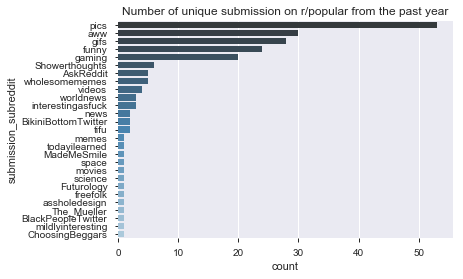

In [13]:
ax = sns.countplot(y = 'submission_subreddit', data = popular_df, 
                   order = popular_df['submission_subreddit'].value_counts().index,
                  palette = 'Blues_d').set_title('Number of unique submission on r/popular from the past year')

- r/pics is by far the most common subreddit to show up on the front page with over 50 unique submission. 

- r/aww, r/gifs, r/funny all have around half as much submissions going to the front page.

- There are some interesting subreddit submissions that show up like r/The_Mueller and r/freefolk. The Mueller Report was a hot political topic from the past year. Freefolk which is a subreddit for Game of Thrones was also a hot topic since it was the final season of the show. I suspect that these two subreddits wouldn't show up if we were to expand our analysis further than a year

### What is the average number of upvotes of each subreddit submission?

In [14]:
mean_upvotes = popular_df.groupby(['submission_subreddit'])['num_upvotes'].mean()
mean_upvotes = mean_upvotes.sort_values(ascending = False).reset_index()

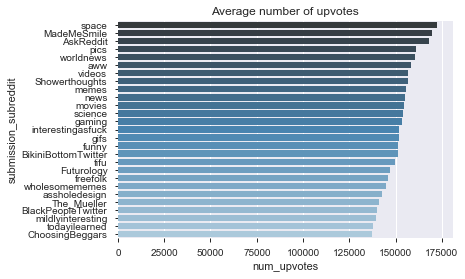

In [15]:
ax = sns.barplot(y = 'submission_subreddit' , x = 'num_upvotes', data = mean_upvotes, ci = False, palette = 'Blues_d',
                order = mean_upvotes['submission_subreddit']).set_title('Average number of upvotes')

- r/space has the highest average number of upvotes even though it only had one submission rise to the top of r/popular.

### What is the average number of comments of each subreddit submission?

In [16]:
mean_comments = popular_df.groupby(['submission_subreddit'])['num_comments'].mean()
mean_comments = mean_comments.sort_values(ascending = False).reset_index()

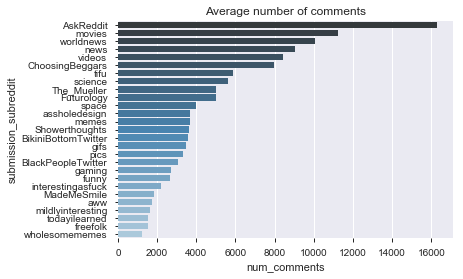

In [17]:
ax = sns.barplot(y = 'submission_subreddit', x = 'num_comments', data = mean_comments, ci  = False, palette = 'Blues_d',
                order = mean_comments['submission_subreddit']).set_title('Average number of comments')

- r/askreddit has the highest average number of comments by far. Which makes sense this subreddit is about posing a question to the Reddit community.
- The next few subreddits also follow this trend of mainly having a discussion element to their submissions. These subreddits include r/movies, r/worldnews, and r/news.
- Even though r/aww had the most submission showing up to the front page. It had one of the fewest average number of comments. Seeing how this subreddit is mainly pictures, there isn't much discussion going on in these submissions.

### What is the average upvote ratio for each subreddit submission?

In [18]:
mean_upvote_ratio = popular_df.groupby(['submission_subreddit'])['upvote_ratio'].mean()
mean_upvote_ratio = mean_upvote_ratio.sort_values(ascending = False).reset_index()

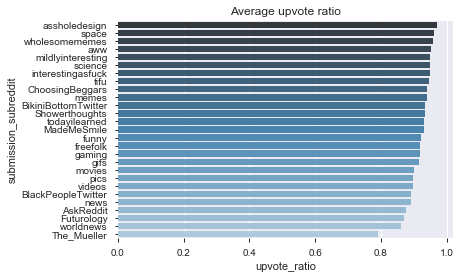

In [19]:
ax = sns.barplot(y = 'submission_subreddit', x = 'upvote_ratio', data = mean_upvote_ratio, ci = False, palette = 'Blues_d',
                order = mean_upvote_ratio['submission_subreddit']).set_title('Average upvote ratio')

- While most subreddit submissions have similar upvote ratios, r/The_Mueller stands out to me. This subreddit submission had less than 0.8 upvote ratios. Reddit allows you to sort submissions by 'Controversial' which is upvote ration close to 0.5. The Mueller Report was a controversial political topic so this makes sense how it had a lower upvote ratio than others.

## Conclusion

There was some interesting insights from looking at the subreddit submission from the past year. Some interesting subreddits that showed up was the_Mueller and freefolk. One is a controversial political topic in our current political climate. The other is popular TV show that millions people watch. 

In future iterations of this analysis. I may want to expand the timeframe beyond a year or even include more than 200 rows of data. By increasing the dataset size, we may see some changes that we can pull more interesting insight to front page of Reddit.